In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys
import seaborn as sns

sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading,ripple_psth

import nelpy as nel
import nelpy.plotting as npl

import os

import pickle
import scipy.stats as stats

import glob

from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
functions.set_plotting_defaults()
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [22]:
import importlib
importlib.reload(ripple_psth)

df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_psth'
ripple_psth.main_run(df,save_path,parallel=True)

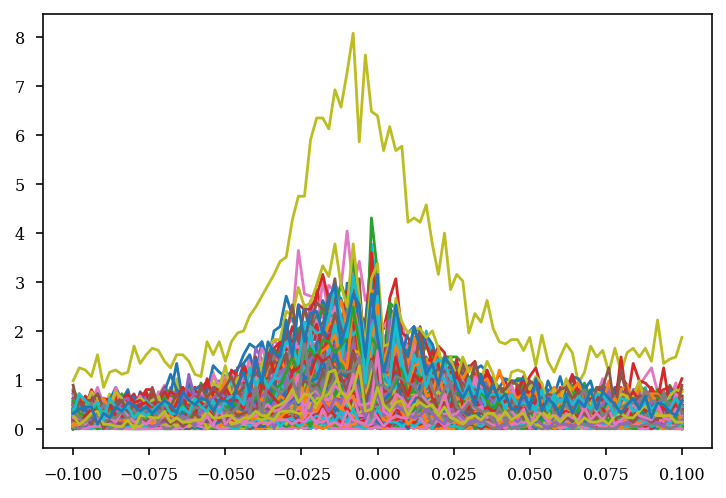

In [3]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_psth'

sessions = glob.glob(save_path +os.sep+ '*.pkl')

# # par_assem_df = pd.DataFrame()
# for session in sessions:
#     with open(session, 'rb') as f:
#         results = pickle.load(f)

with open(sessions[0], 'rb') as f:
    results = pickle.load(f)
plt.plot(results['ccg'][0])
plt.show()

In [5]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability')
df = df[df.basepath.str.contains('GrosmarkAD')]

In [19]:
df.keys()

Index(['Unnamed: 0', 'UID', 'basepath', 'epoch', 'epoch_n', 'familiarity',
       'deepSuperficial', 'brainRegion', 'putativeCellType',
       'participation_prob', 'participation_prob_nrem',
       'participation_prob_wake', 'avg_fr_not_rip', 'avg_fr_in_rip',
       'n_spikes', 'avg_fr_not_rip_nrem', 'avg_fr_in_rip_nrem',
       'n_spikes_nrem', 'avg_fr_not_rip_wake', 'avg_fr_in_rip_wake',
       'n_spikes_wake', 'session_dur', 'session_dur_nrem', 'session_dur_wake',
       'n_ripples', 'n_ripples_nrem', 'n_ripples_wake'],
      dtype='object')

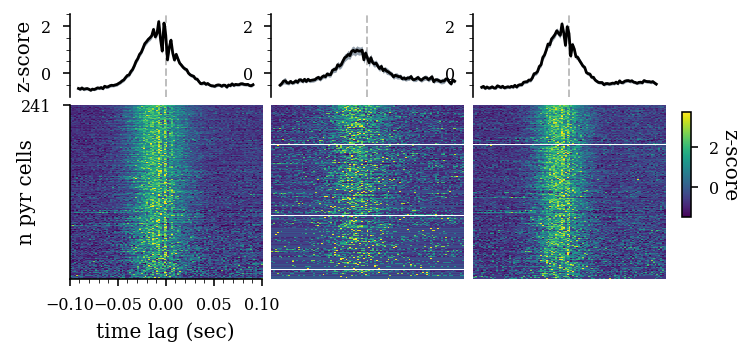

In [50]:
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_psth'

sessions = glob.glob(save_path +os.sep+ '*.pkl')
with open(sessions[0], 'rb') as f:
    results = pickle.load(f)

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2,3)),constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.05)

y_min = -1
y_max = 2.5
heatmap_factor = 1.5

# mean CI plots
ax0 = fig.add_subplot(gs[0, 0])
lower,upper= confidence_intervals(stats.zscore(results['ccg'][0]).values.T)
ax0.plot(results['ccg'][0].index,np.nanmean(stats.zscore(results['ccg'][0]),axis=1),'k')
ax0.fill_between(results['ccg'][0].index, lower, upper, color="slategrey", alpha = 0.75, linewidth = 0)

ax1 = fig.add_subplot(gs[0, 1])
lower,upper= confidence_intervals(stats.zscore(results['ccg'][1]).values.T)
ax1.plot(results['ccg'][1].index,np.nanmean(stats.zscore(results['ccg'][1]),axis=1),'k')
ax1.fill_between(results['ccg'][1].index, lower, upper, color="slategrey", alpha = 0.75, linewidth = 0)

ax2 = fig.add_subplot(gs[0, 2])
lower,upper= confidence_intervals(stats.zscore(results['ccg'][2]).values.T)
ax2.plot(results['ccg'][2].index,np.nanmean(stats.zscore(results['ccg'][2]),axis=1),'k')
ax2.fill_between(results['ccg'][2].index, lower, upper, color="slategrey", alpha = 0.75, linewidth = 0)

# heatmaps
# pull participation prob. for sorting
participation_prob_nrem = df[(df.epoch_n == 0) & (df.basepath == results['basepath'])].participation_prob_nrem
sort_idx = np.argsort(-participation_prob_nrem)

ax3 = fig.add_subplot(gs[1:,0])
extent = [results['ccg'][0].index.min(),results['ccg'][0].index.max(),0,results['ccg'][0].shape[1]]
ax3.imshow(stats.zscore(results['ccg'][0])[sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
ax3.set_yticks([stats.zscore(results['ccg'][0]).shape[1]])

ax4 = fig.add_subplot(gs[1:,1])
extent = [results['ccg'][1].index.min(),results['ccg'][1].index.max(),0,results['ccg'][1].shape[1]]
ax4.imshow(stats.zscore(results['ccg'][1])[sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)

ax5 = fig.add_subplot(gs[1:,2])
extent = [results['ccg'][2].index.min(),results['ccg'][2].index.max(),0,results['ccg'][2].shape[1]]
sm = ax5.imshow(stats.zscore(results['ccg'][2])[sort_idx].T,aspect='auto',interpolation='nearest',extent=extent,vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)


axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2]
for i in range(3):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey',zorder=-100)

axs = [ax4,ax5]
for i in range(2):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axes.get_yaxis().set_ticks([])

# ax4.spines["bottom"].set_visible(False)

ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)
ax2.set_ylim(y_min,y_max)

ax0.set_ylabel('z-score')

ax3.set_xlabel('time lag (sec)')
ax3.set_ylabel('n pyr cells',labelpad=-7.5)

# norm = MidpointNormalize(vmin=y_min*heatmap_factor, vmax=y_max*heatmap_factor, midpoint=0)

# sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('PuOr'), norm=norm)
# sm.set_array([])
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('z-score', rotation=270, labelpad=10)

plt.savefig(os.path.join(fig_save_path,'ripple_psth_heatmap.svg'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\AppData\Local\Temp/ipykernel_21600/1941760826.py:1: RuntimeWarning: All-NaN axis encountered


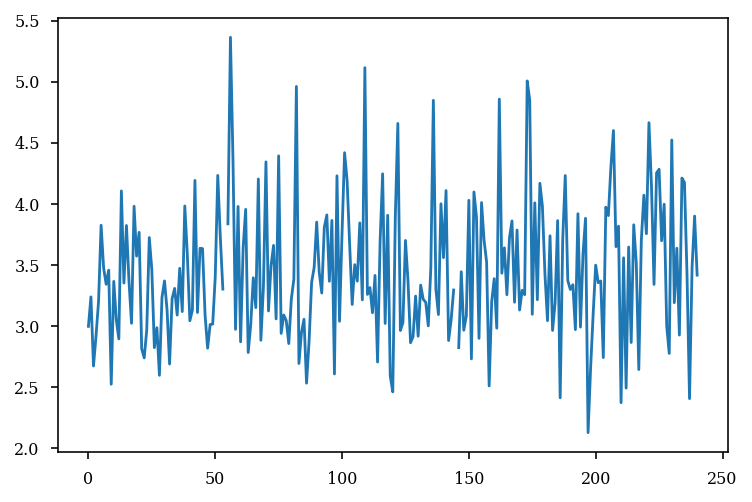

In [57]:
plt.plot(np.nanmax(stats.zscore(results['ccg'][2])[sort_idx],axis=0))

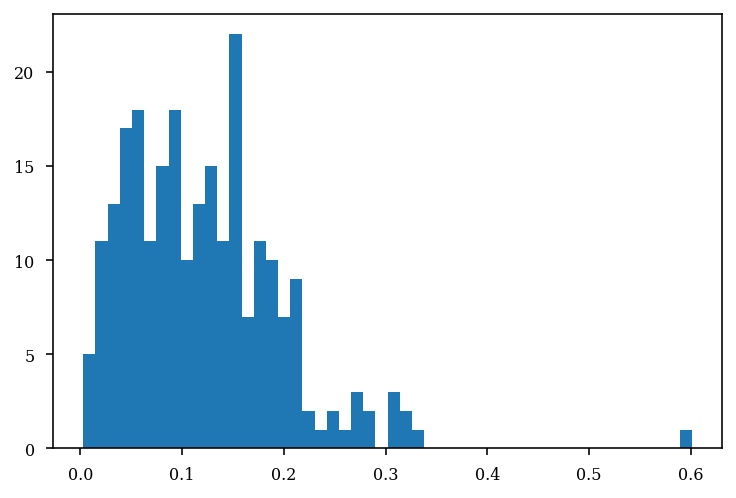

In [132]:
plt.hist(participation_prob_nrem,50)
plt.show()

In [148]:
zscored.loc[100:200,:]

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
100,0.060538,-0.252887,-0.392134,-0.295415,-0.614294,-0.730771,-0.545285,-0.548417,0.122529,0.037912,...,-0.425807,-0.113459,-0.110003,-0.126039,0.246084,0.123809,-0.086061,-0.105966,0.120474,0.292611
101,-1.044465,-1.076809,-0.840498,-0.717635,-1.325261,-1.124063,-0.545285,-0.765066,-1.065515,-0.855541,...,-0.738708,-0.877419,-1.016962,-0.934292,-0.934783,-1.007268,-0.775919,-0.770262,-0.703533,-0.617513
102,-0.712964,-1.351450,-0.840498,-0.717635,-1.325261,-0.730771,-0.545285,-0.548417,-1.065515,-0.855541,...,-0.738708,-0.877419,-1.016962,-0.934292,-0.934783,-1.007268,-1.051862,-0.770262,-0.703533,-0.693357
103,-0.933965,-1.076809,-0.840498,-0.717635,-1.040874,-1.124063,-0.545285,-0.981716,-1.065515,-1.110813,...,-0.738708,-0.781924,-1.016962,-0.934292,-0.934783,-1.007268,-0.775919,-0.770262,-0.703533,-0.693357
104,-0.933965,-1.214130,-0.840498,-0.717635,-1.183067,-0.730771,-0.545285,-0.981716,-1.065515,-0.983177,...,-0.738708,-0.877419,-0.903592,-0.934292,-0.934783,-1.007268,-0.913890,-0.770262,-0.703533,-0.693357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.602464,-1.214130,-0.840498,-0.717635,-1.183067,-1.124063,-0.545285,-0.765066,-1.065515,-0.983177,...,-0.738708,-0.781924,-1.016962,-0.732228,-0.934783,-1.007268,-0.913890,-0.770262,-0.703533,-0.693357
197,-0.602464,-0.939489,-0.840498,-0.717635,-1.183067,-1.124063,-0.545285,-0.981716,-1.065515,-1.110813,...,-0.738708,-0.877419,-0.903592,-0.934292,-0.934783,-0.818755,-1.051862,-0.770262,-0.703533,-0.693357
198,-0.933965,-1.351450,-0.392134,-0.717635,-1.183067,-0.730771,-0.545285,-0.765066,-1.065515,-0.983177,...,-0.738708,-0.877419,-1.016962,-0.934292,-0.934783,-0.818755,-1.051862,-0.770262,-0.703533,-0.693357
199,-0.933965,-1.351450,-0.840498,-0.717635,-0.898681,-0.337479,-0.545285,-0.981716,-0.966512,-0.983177,...,-0.738708,-0.877419,-0.903592,-0.732228,-0.766088,-1.007268,-0.913890,-0.770262,-0.703533,-0.693357


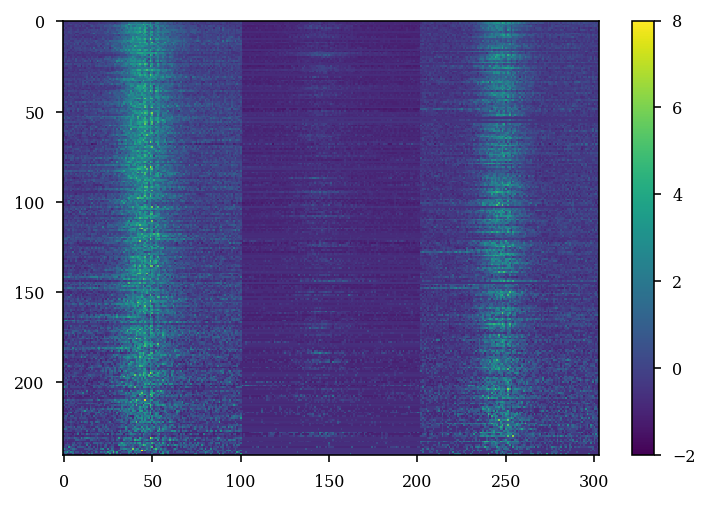

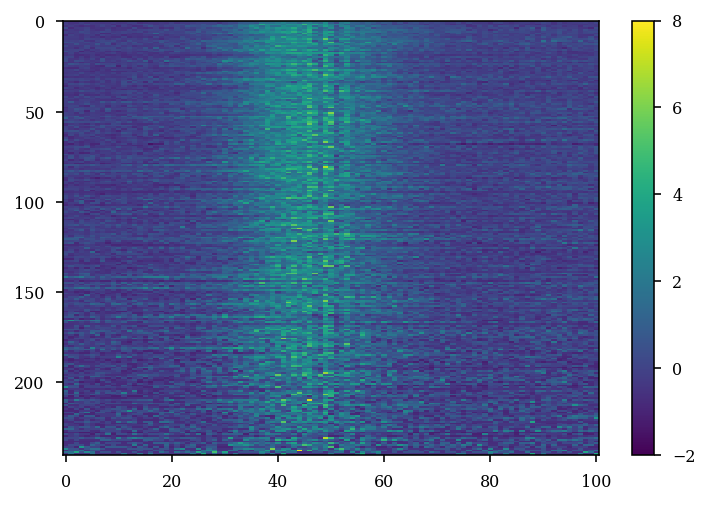

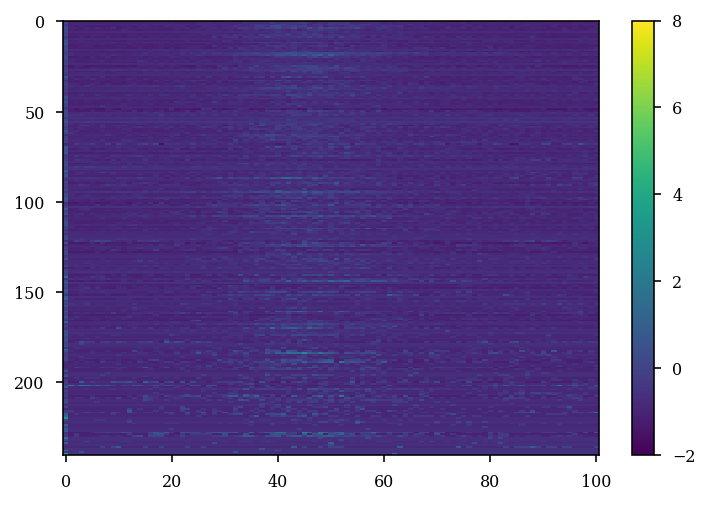

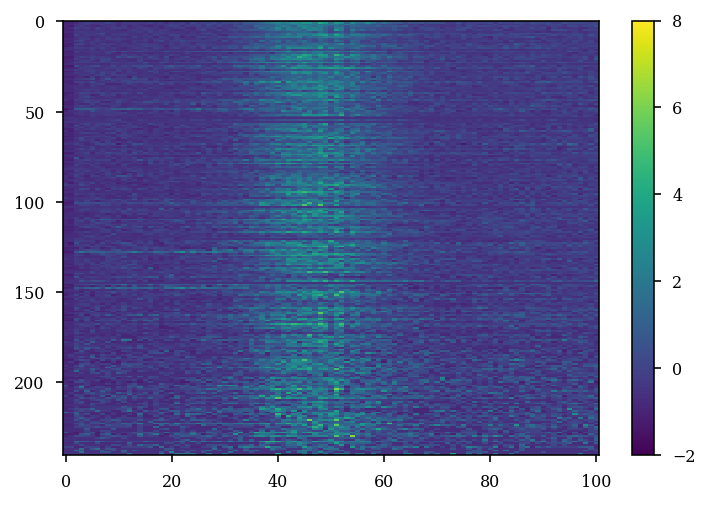

In [160]:
temp_df = pd.DataFrame()
temp_df = temp_df.append(results['ccg'][0],ignore_index=True)
temp_df = temp_df.append(results['ccg'][1],ignore_index=True)
temp_df = temp_df.append(results['ccg'][2],ignore_index=True)
zscored = stats.zscore(temp_df,axis=0)
# plt.imshow(temp_df[sort_idx].T,aspect='auto',interpolation='nearest')

y_min = -2
y_max = 8
plt.imshow(zscored[sort_idx].T,aspect='auto',interpolation='nearest',vmin=y_min,vmax=y_max)
plt.colorbar()
plt.show()

plt.imshow(zscored.loc[0:100,:][sort_idx].T,aspect='auto',interpolation='nearest',vmin=y_min,vmax=y_max)
plt.colorbar()
plt.show()

plt.imshow(zscored.loc[100:200,:][sort_idx].T,aspect='auto',interpolation='nearest',vmin=y_min,vmax=y_max)
plt.colorbar()
plt.show()

plt.imshow(zscored.loc[200:300,:][sort_idx].T,aspect='auto',interpolation='nearest',vmin=y_min,vmax=y_max)
plt.colorbar()
plt.show()

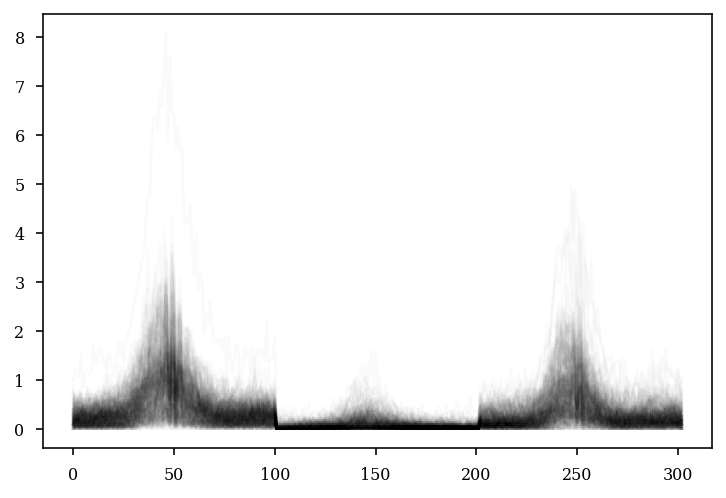

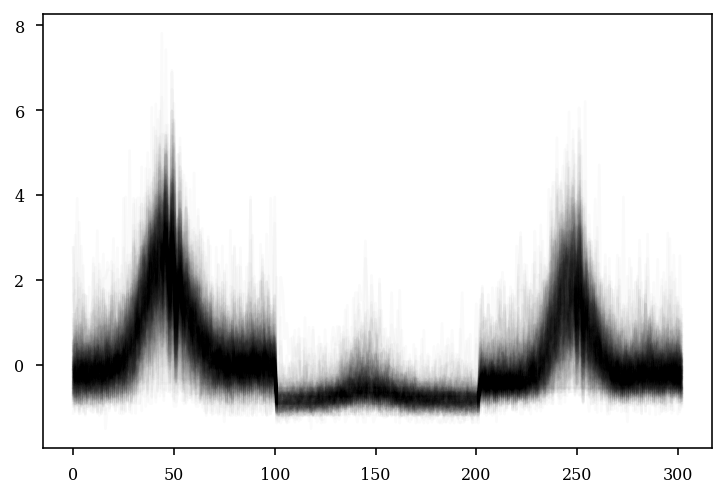

In [158]:
plt.plot(temp_df,color='k',alpha=.02)
plt.show()
plt.plot(stats.zscore(temp_df,axis=0),color='k',alpha=.02)
plt.show()

In [104]:
np.concatenate([results['ccg'][0].values, results['ccg'][1].values],-1).shape

(101, 482)

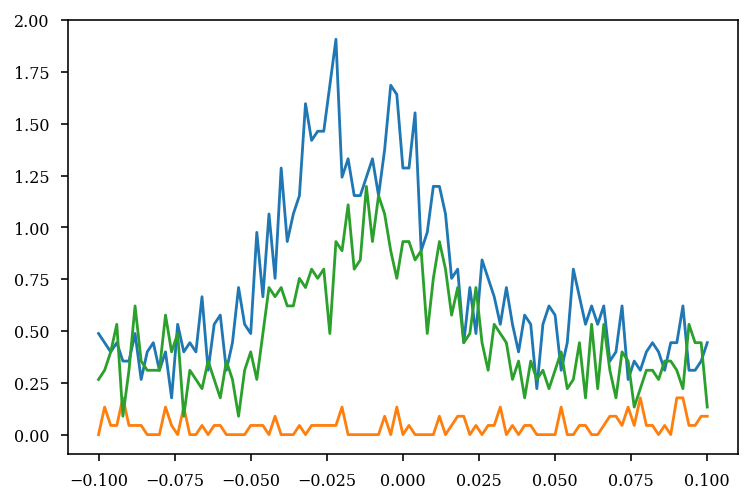

In [93]:
for i in results['ccg'][0].shape[1]:
    
plt.plot(results['ccg'][0][0])
plt.plot(results['ccg'][1][0])
plt.plot(results['ccg'][2][0])

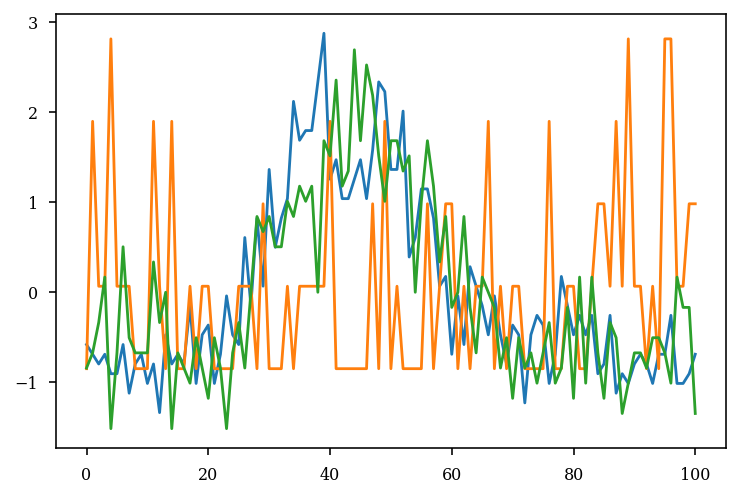

In [86]:
plt.plot(stats.zscore(results['ccg'],axis=1)[0][:,0])
plt.plot(stats.zscore(results['ccg'],axis=1)[1][:,0])
plt.plot(stats.zscore(results['ccg'],axis=1)[2][:,0])


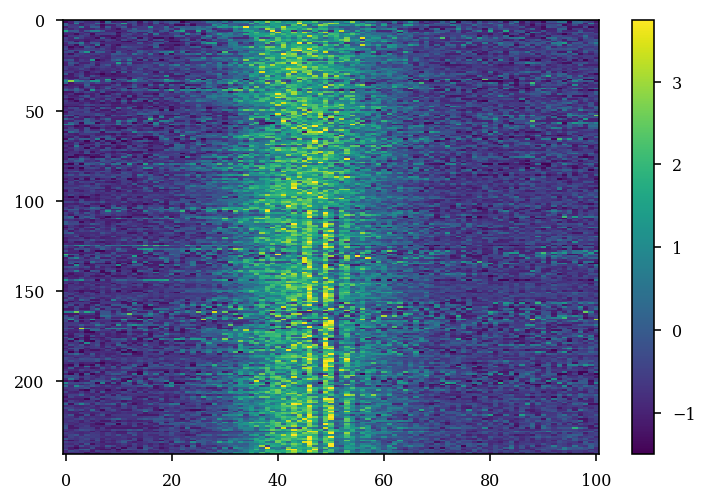

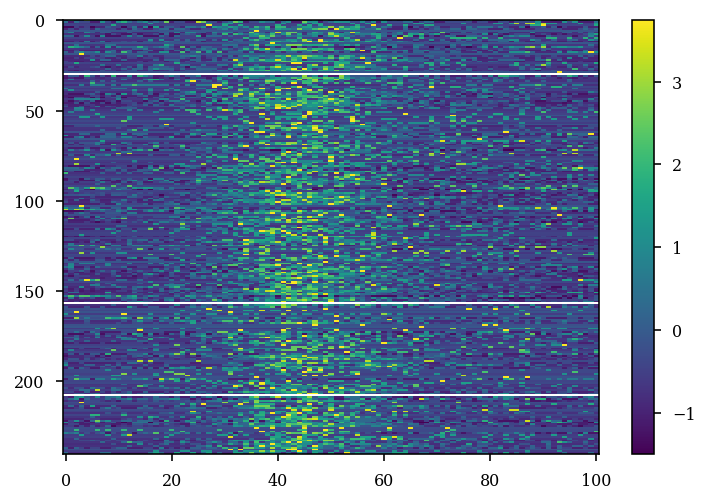

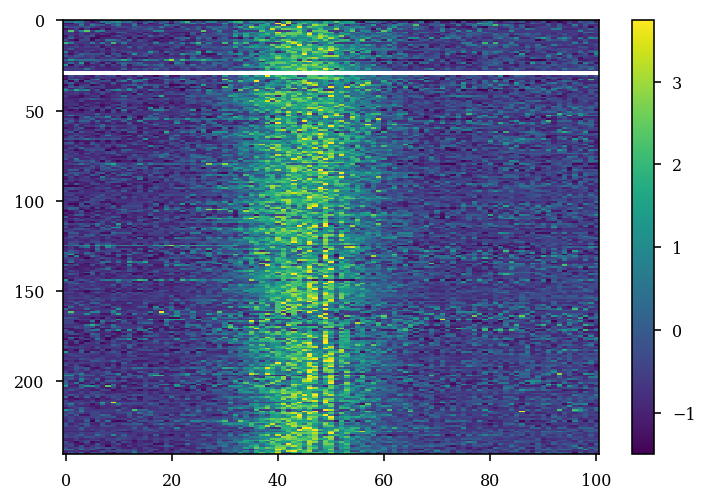

In [77]:
plt.imshow(stats.zscore(results['ccg'],axis=1)[0].T,aspect='auto',interpolation='nearest',vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
plt.colorbar()
plt.show()

plt.imshow(stats.zscore(results['ccg'],axis=1)[1].T,aspect='auto',interpolation='nearest',vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
plt.colorbar()
plt.show()

plt.imshow(stats.zscore(results['ccg'],axis=1)[2].T,aspect='auto',interpolation='nearest',vmin=y_min*heatmap_factor,vmax=y_max*heatmap_factor)
plt.colorbar()
plt.show()
